In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline

In [2]:
print("### Part 1: Exploratory Data Analysis ###\n")

# Load the dataset
try:
    df = pd.read_csv('/content/processed.csv')
except FileNotFoundError:
    print("Error: The file 'processed.csv' was not found.")
    print("Please make sure the file is in the same directory as this script.")
    exit()

### Part 1: Exploratory Data Analysis ###



In [3]:
# Display basic information about the dataset
print("--- Dataset Information ---")
print(df.head())
print("\n")
df.info()
print("\n")
print(df.describe(include='all'))
print("\n")

--- Dataset Information ---
   Unnamed: 0                                             review  sentiment
0           0  one reviewer mention watch oz episode youll ho...          1
1           1  wonderful little production film technique una...          1
2           2  thought wonderful way spend time hot summer we...          1
3           3  basically there family little boy jake think t...          0
4           4  petter matteis love time money visually stun f...          1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50000 non-null  int64 
 1   review      50000 non-null  object
 2   sentiment   50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


          Unnamed: 0                                             review  \
count   50000.000000                                              50000   
uniq

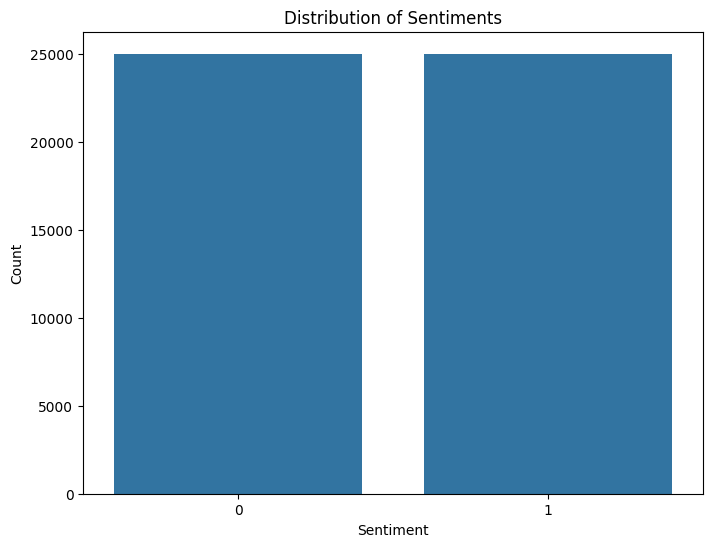

In [4]:
# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

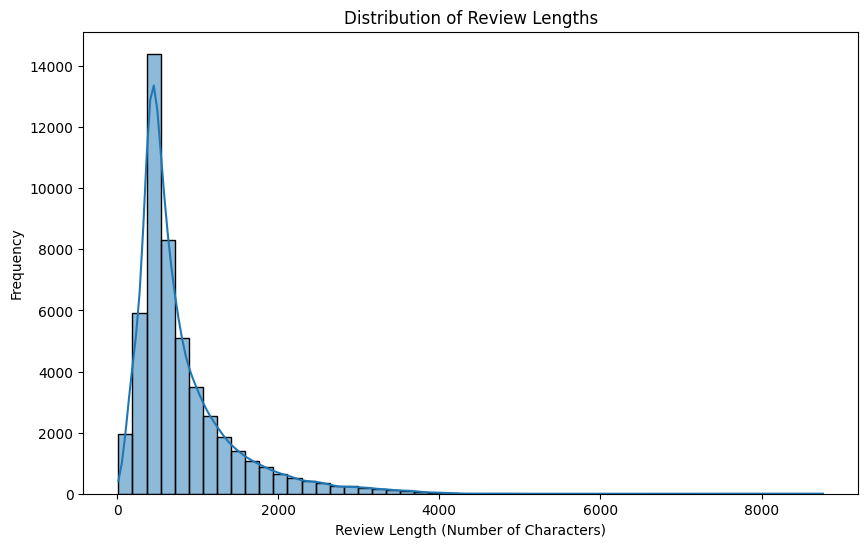

In [5]:
# Visualize the length of reviews
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

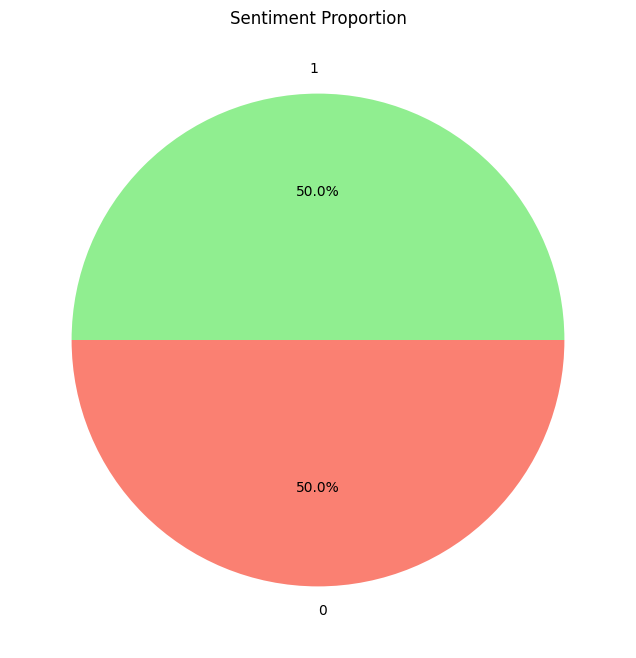

In [6]:
plt.figure(figsize=(8, 8))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
plt.title('Sentiment Proportion')
plt.ylabel('')
plt.show()

/tmp/ipython-input-2820526136.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='sentiment', y='review_length', data=df, inner='quartile', palette='Set2')


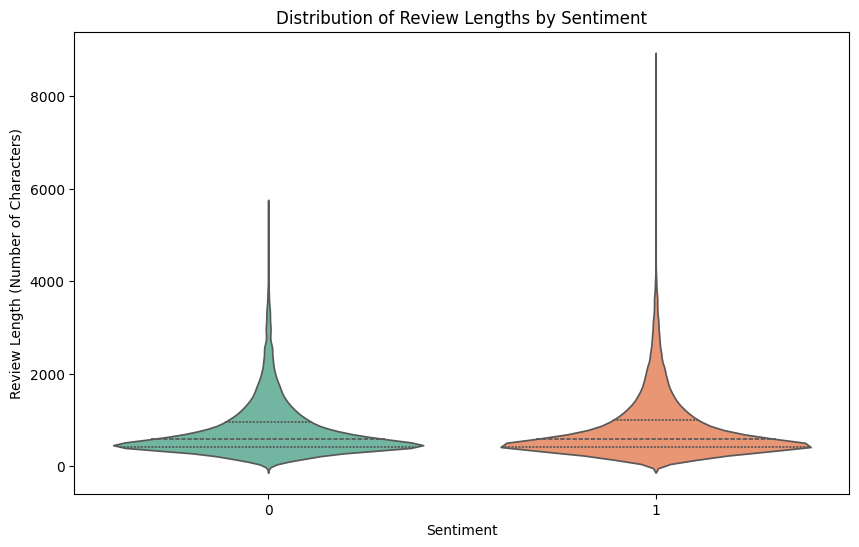

In [7]:
# --- Violin Plot: Review Length vs Sentiment ---
# Recreate the 'review_length' column as it was dropped in a previous cell
df['review_length'] = df['review'].apply(len)

plt.figure(figsize=(10, 6))
sns.violinplot(x='sentiment', y='review_length', data=df, inner='quartile', palette='Set2')
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Number of Characters)')
plt.show()

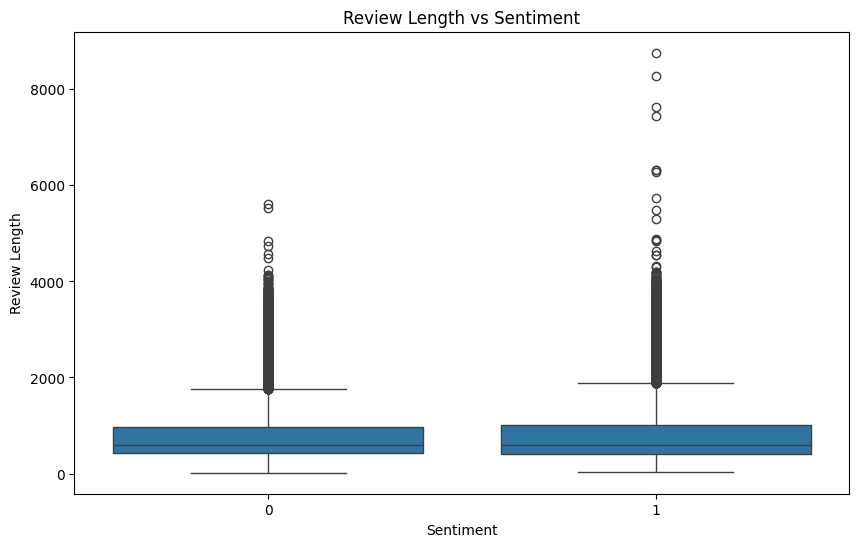

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y=df['review'].apply(len), data=df)
plt.title('Review Length vs Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

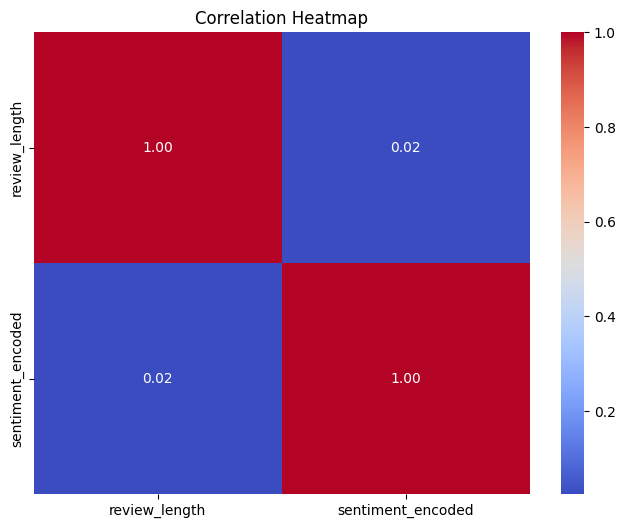

In [9]:
df['sentiment_encoded'] = df['sentiment'].astype('category').cat.codes

plt.figure(figsize=(8, 6))
sns.heatmap(df[['review_length', 'sentiment_encoded']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


/tmp/ipython-input-3659882278.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_scores), y=list(pos_words), palette="Greens_r")


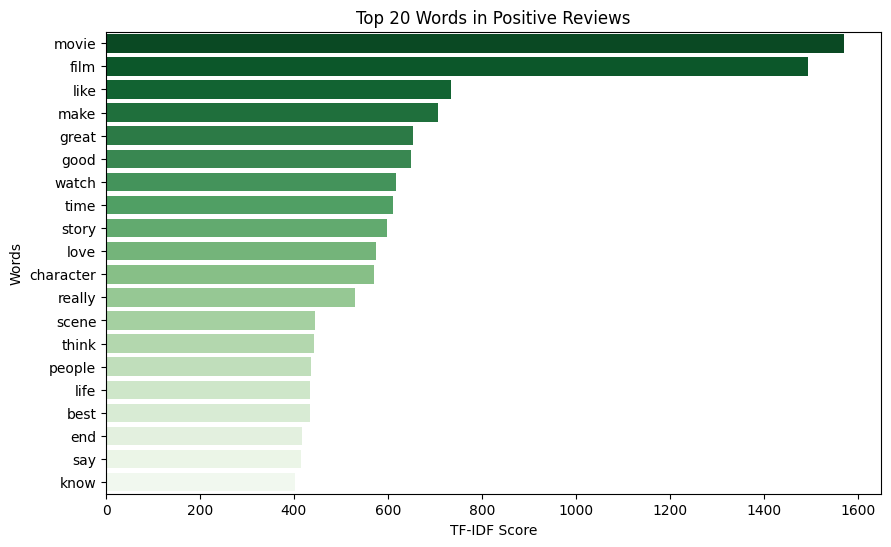

/tmp/ipython-input-3659882278.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(neg_scores), y=list(neg_words), palette="Reds_r")


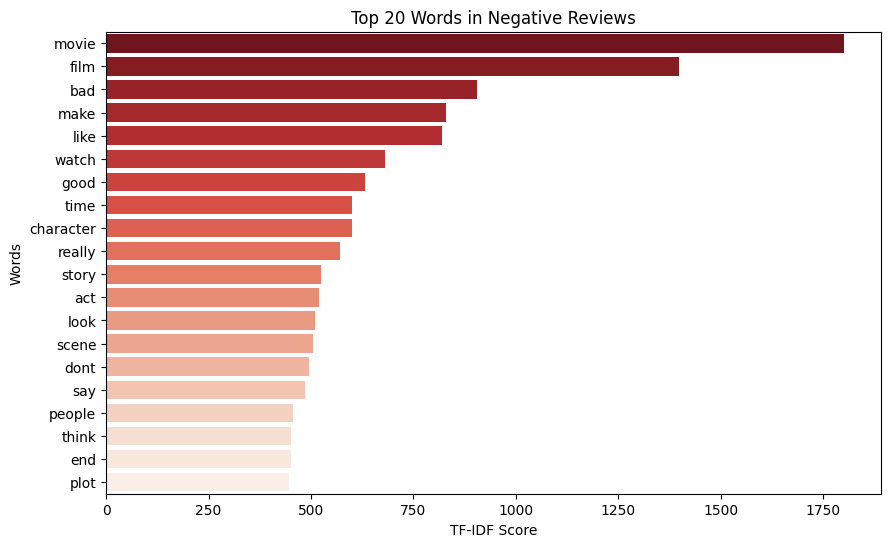

In [10]:
# --- New Addition: Top 20 words in positive and negative reviews ---
def get_top_words(corpus, n=20):
    vec = TfidfVectorizer(stop_words='english', max_features=5000)
    X = vec.fit_transform(corpus)
    word_scores = X.sum(axis=0).A1
    words = vec.get_feature_names_out()
    sorted_words = sorted(zip(words, word_scores), key=lambda x: x[1], reverse=True)
    return sorted_words[:n]

positive_reviews = df[df['sentiment'] == 1.0]['review']
negative_reviews = df[df['sentiment'] == 0.0]['review']

top_pos = get_top_words(positive_reviews)
top_neg = get_top_words(negative_reviews)

# Plot positive words
pos_words, pos_scores = zip(*top_pos)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(pos_scores), y=list(pos_words), palette="Greens_r")
plt.title("Top 20 Words in Positive Reviews")
plt.xlabel("TF-IDF Score")
plt.ylabel("Words")
plt.show()

# Plot negative words
neg_words, neg_scores = zip(*top_neg)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(neg_scores), y=list(neg_words), palette="Reds_r")
plt.title("Top 20 Words in Negative Reviews")
plt.xlabel("TF-IDF Score")
plt.ylabel("Words")
plt.show()

In [11]:
# --- Part 2: Model Training and Evaluation ---
print("\n### Part 2: Model Training and Evaluation ###\n")

# Drop rows with missing values and the temporary review_length column
df.dropna(inplace=True)
# df.drop('review_length', axis=1, inplace=True) # Removed this line

# Define features (X) and target (y)
X = df['review']
y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list of models to evaluate
models = [
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000)),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Random Forest Classifier', RandomForestClassifier(random_state=42))
]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models:
    print(f"\n--- Training and evaluating {name} ---")

    # Create a pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', model)
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the results
    results[name] = {'Accuracy': accuracy, 'F1-Score': f1}

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Find the best performing model
best_model_name = max(results, key=lambda k: results[k]['Accuracy'])
best_model_accuracy = results[best_model_name]['Accuracy']
best_model_f1 = results[best_model_name]['F1-Score']

print("\n" + "="*50)
print("Summary of Results:")
for name, scores in results.items():
    print(f"{name:<25}: Accuracy = {scores['Accuracy']:.4f}, F1-Score = {scores['F1-Score']:.4f}")
print("="*50)

print(f"\nThe best model is '{best_model_name}' with an Accuracy of {best_model_accuracy:.4f} and F1-Score of {best_model_f1:.4f}.")

# Provide an example prediction for the best model
print("\n" + "="*50)
print("Example Prediction:")
best_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', models[[m[0] for m in models].index(best_model_name)][1])
])
best_pipeline.fit(X_train, y_train)
new_review = ["This movie was ok"]
predicted_sentiment = best_pipeline.predict(new_review)
print(f"The review: '{new_review[0]}'")
print(f"The predicted sentiment is: {predicted_sentiment[0]}")
print("="*50)


### Part 2: Model Training and Evaluation ###


--- Training and evaluating Logistic Regression ---
Accuracy: 0.8798
F1-Score: 0.8797

--- Training and evaluating Multinomial Naive Bayes ---
Accuracy: 0.8451
F1-Score: 0.8451

--- Training and evaluating Random Forest Classifier ---
Accuracy: 0.8447
F1-Score: 0.8447

Summary of Results:
Logistic Regression      : Accuracy = 0.8798, F1-Score = 0.8797
Multinomial Naive Bayes  : Accuracy = 0.8451, F1-Score = 0.8451
Random Forest Classifier : Accuracy = 0.8447, F1-Score = 0.8447

The best model is 'Logistic Regression' with an Accuracy of 0.8798 and F1-Score of 0.8797.

Example Prediction:
The review: 'This movie was ok'
The predicted sentiment is: 0


In [12]:
while True:
    user_review = input("Enter a review (or type 'exit' to quit): ")
    if user_review.lower() == "exit":
        print("Exiting...")
        break
    prediction = best_pipeline.predict([user_review])
    print(f"Review: {user_review}")
    print(f"Predicted Sentiment: {prediction[0]}")
    print("="*50)

Enter a review (or type 'exit' to quit): A must-watch! This movie is not just a film but an experience that will stay with you. Highly recommended for anyone who loves cinema with heart and soul.
Review: A must-watch! This movie is not just a film but an experience that will stay with you. Highly recommended for anyone who loves cinema with heart and soul.
Predicted Sentiment: 1
Enter a review (or type 'exit' to quit): exit
Exiting...



--- Confusion Matrix for Logistic Regression ---
Accuracy: 0.8798, F1-Score: 0.8797


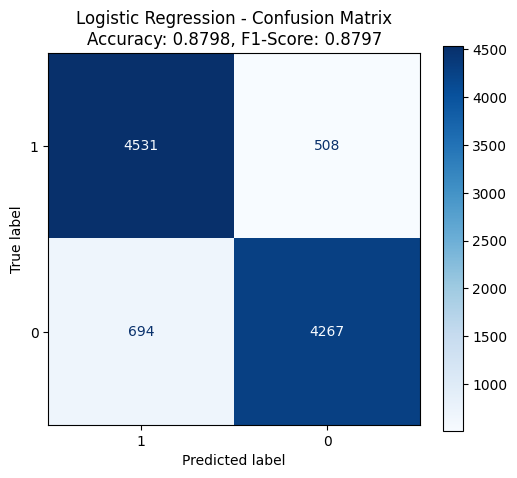


--- Confusion Matrix for Multinomial Naive Bayes ---
Accuracy: 0.8451, F1-Score: 0.8451


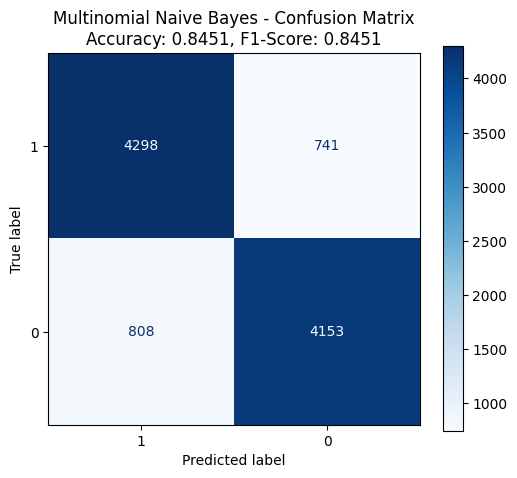


--- Confusion Matrix for Random Forest Classifier ---
Accuracy: 0.8447, F1-Score: 0.8447


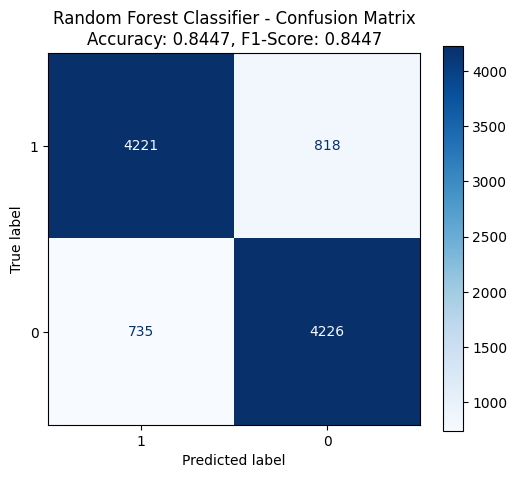

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Loop through all models
for name, model in models:
    print(f"\n--- Confusion Matrix for {name} ---")

    # Train pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)

    # Predict on test set
    y_pred = pipeline.predict(X_test)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=y.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique())

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title(f"{name} - Confusion Matrix\nAccuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")
    plt.show()


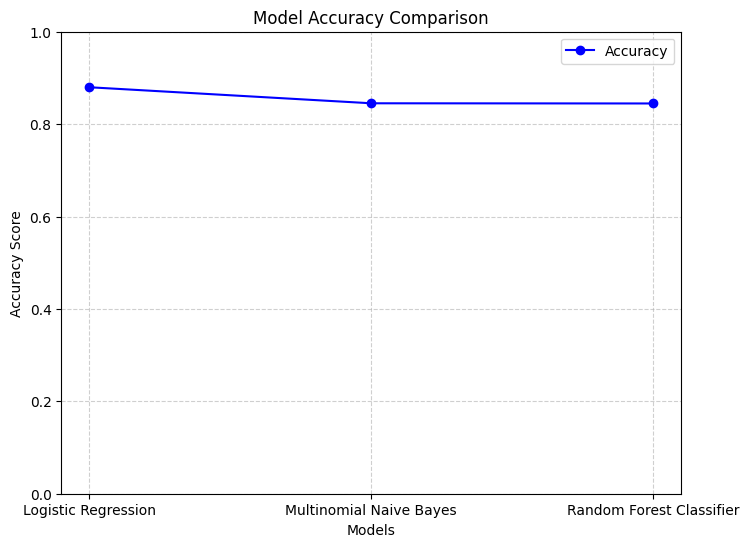

In [14]:
# 🔹 Accuracy Curve Graph
plt.figure(figsize=(8, 6))
model_names = [name for name, _ in models]  # Get names directly from models list
accuracies = [results.get(m, {'Accuracy': 0})['Accuracy'] for m in model_names]
# if model not in results, set accuracy=0

plt.plot(model_names, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)  # Keep y-axis between 0 and 1
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()



--- Feature Importance for Logistic Regression ---


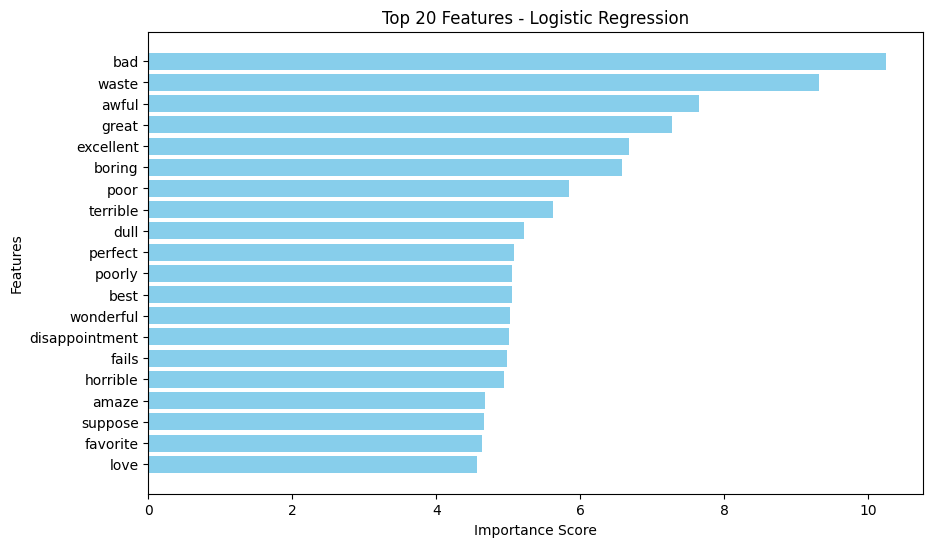


--- Feature Importance for Multinomial Naive Bayes ---


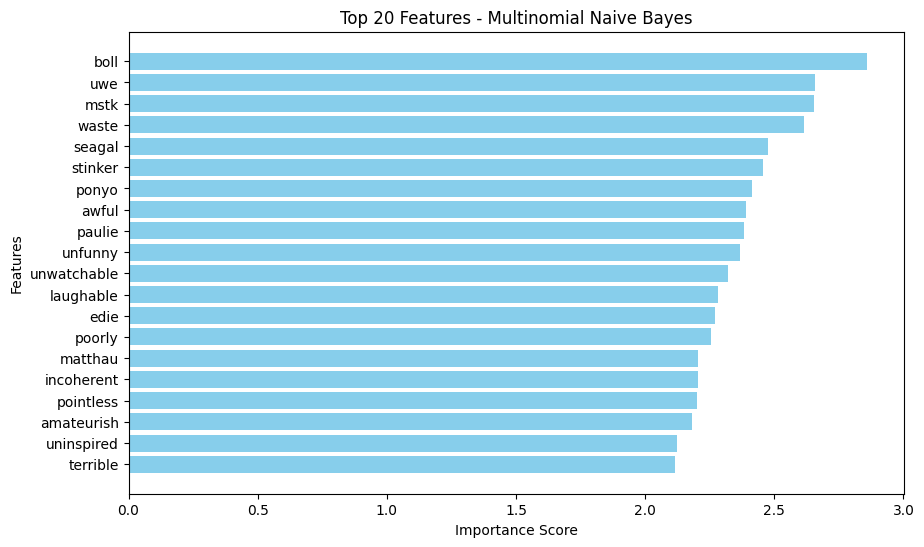


--- Feature Importance for Random Forest Classifier ---


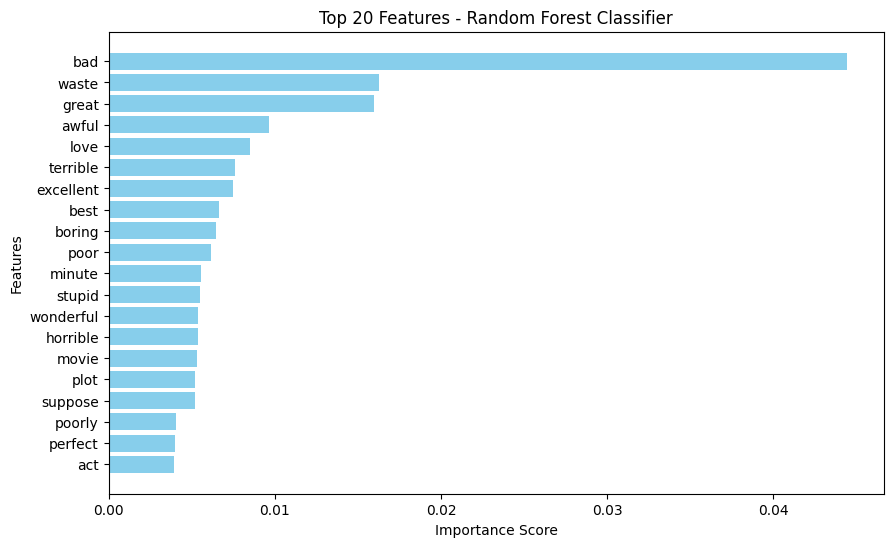

In [15]:
# List of models
models_for_importance = [
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000)),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Random Forest Classifier', RandomForestClassifier(random_state=42))
]

for name, model in models_for_importance:
    print(f"\n--- Feature Importance for {name} ---")

    # Train pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Compute importance based on model type
    if name == 'Random Forest Classifier':
        importances = pipeline.named_steps['classifier'].feature_importances_
    elif name == 'Logistic Regression':
        # Take absolute value of coefficients and average across classes
        importances = abs(pipeline.named_steps['classifier'].coef_).mean(axis=0)
    elif name == 'Multinomial Naive Bayes':
        # Take the difference between log probabilities across classes
        importances = abs(pipeline.named_steps['classifier'].feature_log_prob_[1] -
                          pipeline.named_steps['classifier'].feature_log_prob_[0])

    # Get top 20 features
    indices = importances.argsort()[::-1][:20]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_features[::-1], top_importances[::-1], color='skyblue')
    plt.title(f"Top 20 Features - {name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()
